<a href="https://colab.research.google.com/github/avarlotta/time-series-forecasting/blob/main/subcat_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from google.colab import auth, drive
from google.cloud import bigquery
from prophet import Prophet

In [2]:
client = bigquery.Client(project='prism-insights')
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = Path() / 'drive/My Drive/Colab Notebooks'

In [4]:
sales_query = '''WITH sales AS (
      SELECT date,
             item_sub_category,
             SUM(items_sold) AS num_sales
      FROM `prism-insights.prism_insights_production.stock_forecast_sub_categories`
      GROUP BY 2, 1
      ORDER BY 1)
SELECT *
FROM sales
'''

sales_df = client.query(sales_query).to_dataframe()

In [5]:
sales_df.head()

,date,item_sub_category,num_sales
0,2020-01-01,Belts,12
1,2020-01-01,Socks,99
2,2020-01-01,Scarves & Winter Hats & Gloves,24
3,2020-01-01,Home & Decoration,69
4,2020-01-01,Undershirts,3


In [6]:
stock_query = '''WITH sales AS (
      SELECT item_sub_category,
             average_of_item_price,
             average_of_item_cost,
             discount_price,
             cost_of_overage,
             cost_of_underage,
             (cost_of_overage - cost_of_underage) AS difference
      FROM `prism-insights.prism_insights_production.stock_forecast_purchases`
      ORDER BY difference DESC)
SELECT *
FROM sales
'''

stock_df = client.query(stock_query).to_dataframe()

In [7]:
stock_df.head()

,item_sub_category,average_of_item_price,average_of_item_cost,discount_price,cost_of_overage,cost_of_underage,difference
0,Watches,163.32,96.98,14.34,102.22,61.10,41.12
1,Electronics,163.09,96.32,78.40,101.56,61.53,40.03
2,Eyewear,65.18,41.54,14.64,46.78,18.40,28.38
3,Bags,46.74,24.99,12.43,30.23,16.51,13.72
4,Sports Equipment,12.29,7.46,0.72,12.70,-0.41,13.11


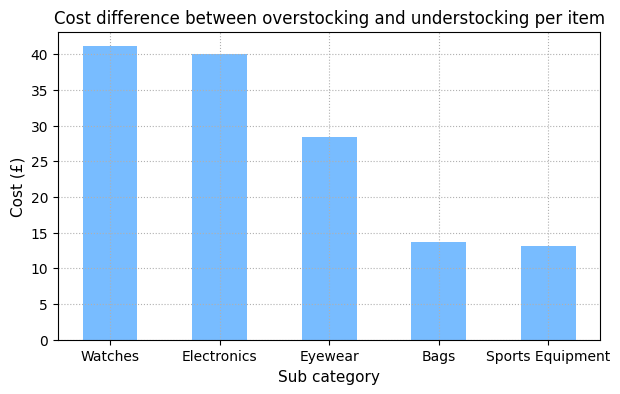

In [8]:
fig, axes = plt.subplots(figsize=(7, 4))
axes.bar(stock_df['item_sub_category'][:5], stock_df['difference'][:5], alpha=0.6, color='dodgerblue', width=0.5)
plt.grid(True, linestyle=':')
axes.set_xlabel('Sub category', fontsize=11)
axes.set_ylabel('Cost (£)', fontsize=11)
axes.set_title('Cost difference between overstocking and understocking per item', fontsize=12);

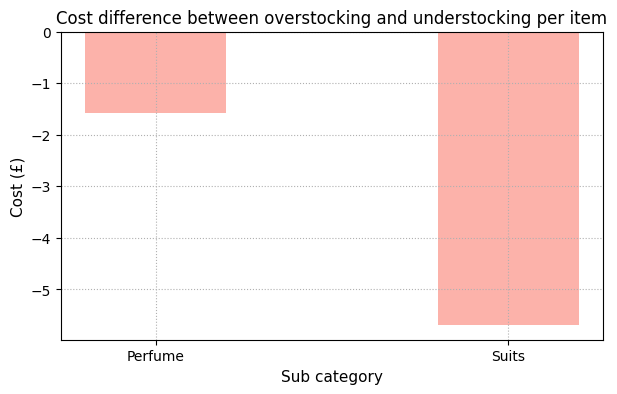

In [9]:
fig, axes = plt.subplots(figsize=(7, 4))
axes.bar(stock_df['item_sub_category'][-2:], stock_df['difference'][-2:], alpha=0.6, color='salmon', width=0.4)
plt.grid(True, linestyle=':')
axes.set_xlabel('Sub category', fontsize=11)
axes.set_ylabel('Cost (£)', fontsize=11)
axes.set_title('Cost difference between overstocking and understocking per item', fontsize=12);

In [10]:
def sub_category_group(sub_cat):
  df = sales_df.groupby(['date', 'item_sub_category']).sum()
  df.reset_index(['date', 'item_sub_category'], inplace=True)
  df = df[df['item_sub_category'] == sub_cat][['date', 'num_sales']]
  df = df.rename(columns={'date': 'ds', 'num_sales': 'y'})
  df.reset_index(drop='index', inplace=True)
  return df

In [38]:
watches_df = sub_category_group('Watches')
electronics_df = sub_category_group('Electronics')
eyewear_df = sub_category_group('Eyewear')
suits_df = sub_category_group('Suits')

In [12]:
def remove_outliers(df, uq):
  df['y'] = df['y'].astype(float)
  Q1 = df['y'].quantile(1 - uq)
  Q3 = df['y'].quantile(uq)
  print(f'Q1: {Q1}, Q3: {Q3}')
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  print(f'lower_bound: {lower_bound}, upper_bound: {upper_bound}')
  df['y'] = df['y'].clip(lower_bound, upper_bound)
  return df

In [39]:
watches_clipped_df = remove_outliers(watches_df, 0.775)
eyewear_clipped_df = remove_outliers(eyewear_df, 0.775)
suits_clipped_df = remove_outliers(suits_df, 0.775)

Q1: 3.0, Q3: 6.0
lower_bound: -1.5, upper_bound: 10.5
Q1: 3.0, Q3: 9.0
lower_bound: -6.0, upper_bound: 18.0
Q1: 3.0, Q3: 6.0
lower_bound: -1.5, upper_bound: 10.5


In [14]:
def run_prophet(df):
  # Initialize Prophet model
  m = Prophet()

  # Add country holidays (if applicable)
  m.add_country_holidays(country_name='UK')

  # Fit the model
  m.fit(df)

  # Create future dataframe
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)

  # Compare forecast to actual values in validation set
  # You can use plots or metrics like MAE, RMSE, etc.

  # Visualize forecast
  fig1 = m.plot(forecast)

  return forecast

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/tt1to6p1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/88h6tb_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45543', 'data', 'file=/tmp/tmp67yzag9m/tt1to6p1.json', 'init=/tmp/tmp67yzag9m/88h6tb_k.json', 'output', 'file=/tmp/tmp67yzag9m/prophet_modelswq79qpk/prophet_model-20231220134145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


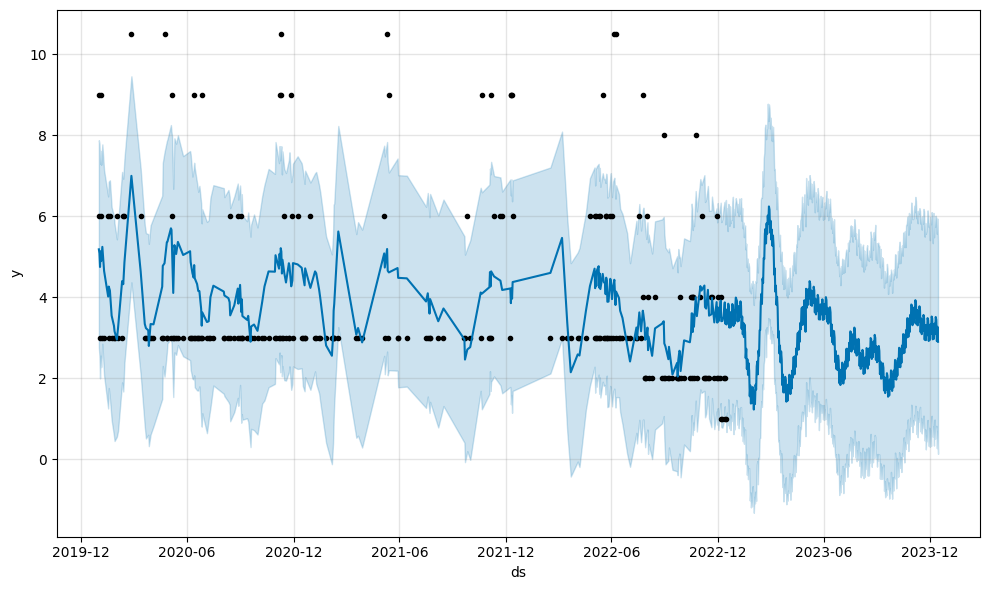

In [15]:
forecast_watches = run_prophet(watches_clipped_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/mlatcpbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/3tofk6iq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9723', 'data', 'file=/tmp/tmp67yzag9m/mlatcpbq.json', 'init=/tmp/tmp67yzag9m/3tofk6iq.json', 'output', 'file=/tmp/tmp67yzag9m/prophet_modelh09lkyh3/prophet_model-20231220134149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


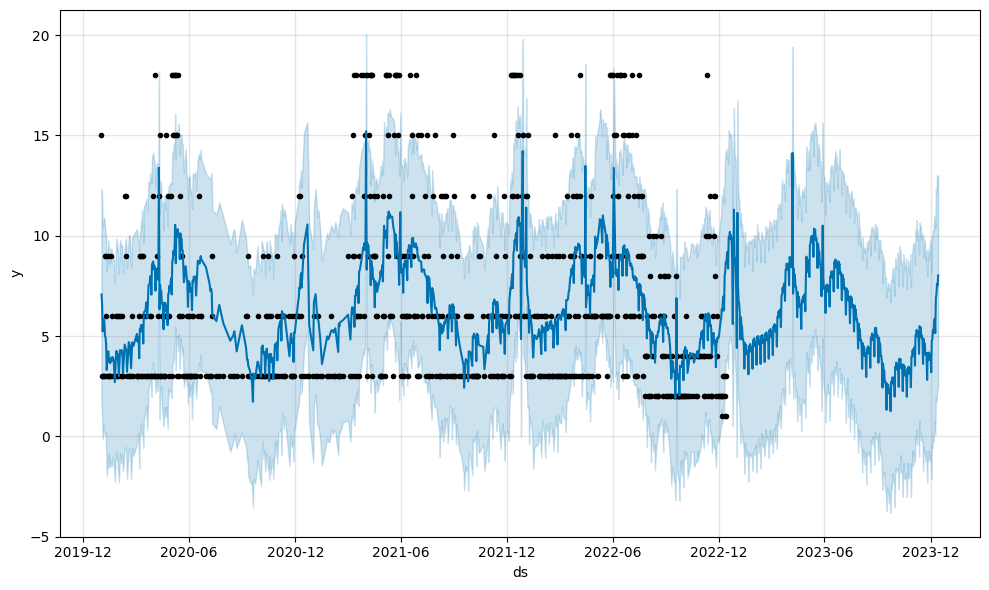

In [16]:
forecast_eyewear = run_prophet(eyewear_clipped_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/epvtjbqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp67yzag9m/nglay22w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33349', 'data', 'file=/tmp/tmp67yzag9m/epvtjbqa.json', 'init=/tmp/tmp67yzag9m/nglay22w.json', 'output', 'file=/tmp/tmp67yzag9m/prophet_modelh5t5fubz/prophet_model-20231220134608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:46:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:46:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


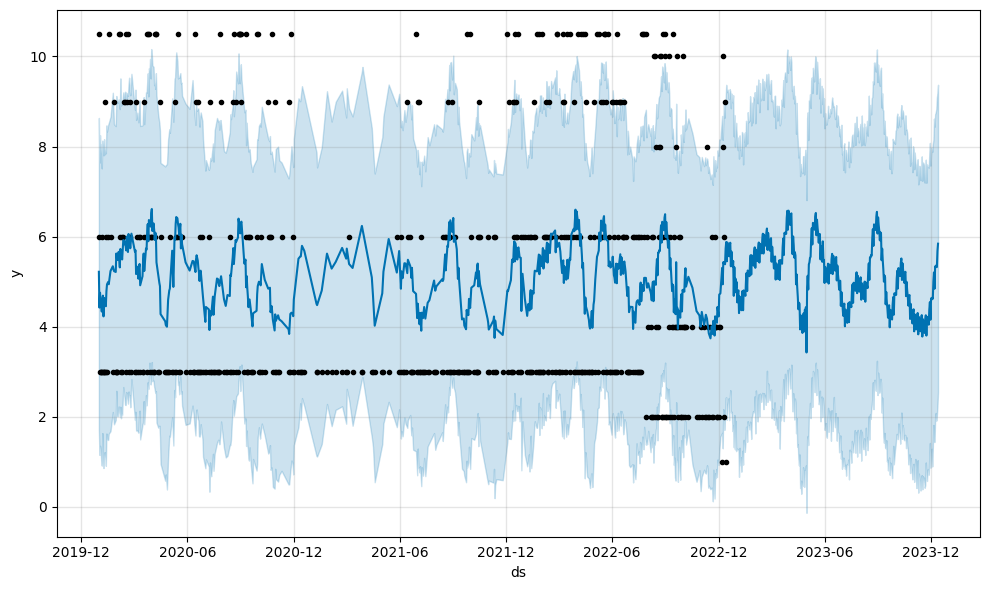

In [40]:
forecast_suits = run_prophet(suits_clipped_df)

In [17]:
def forecast_resampling(forecast, date_lower):
  df = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].set_index('ds').loc[date_lower:]
  weekly_forecast_df = df.resample('W').mean()
  monthly_forecast_df = df.resample('M').mean()
  return weekly_forecast_df, monthly_forecast_df

In [18]:
weekly_forecast_watches_df, monthly_forecast_watches_df = forecast_resampling(forecast_watches, '2022-12-15')

In [19]:
weekly_forecast_watches_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-18,0.932467,3.533771,6.045458
2022-12-25,1.006426,3.536128,6.035547
2023-01-01,1.108411,3.662833,6.211749
2023-01-08,1.088043,3.674036,6.218192
2023-01-15,0.826394,3.412973,5.979596


In [20]:
monthly_forecast_watches_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-31,1.012805,3.561042,6.086332
2023-01-31,0.255686,2.835586,5.398906
2023-02-28,1.285662,3.888359,6.449645
2023-03-31,0.809685,3.378628,5.949427
2023-04-30,0.189475,2.722151,5.270050


In [21]:
weekly_forecast_eyewear_df, monthly_forecast_eyewear_df = forecast_resampling(forecast_eyewear, '2022-12-15')

In [22]:
weekly_forecast_eyewear_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-18,3.982203,9.142701,14.291935
2022-12-25,3.933747,9.163152,14.173044
2023-01-01,3.020546,8.256647,13.457355
2023-01-08,1.804299,7.001123,12.302209
2023-01-15,-0.430121,4.753336,9.938925


In [23]:
monthly_forecast_eyewear_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-31,3.860744,9.064638,14.165591
2023-01-31,-0.239793,5.018625,10.249923
2023-02-28,-0.430041,4.726097,9.877327
2023-03-31,1.342822,6.444836,11.678997
2023-04-30,2.354622,7.531577,12.760946


In [41]:
weekly_forecast_suits_df, monthly_forecast_suits_df = forecast_resampling(forecast_suits, '2022-12-15')

In [45]:
weekly_forecast_suits_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-18,2.224076,5.698232,9.190369
2022-12-25,2.111472,5.581141,9.080903
2023-01-01,1.555500,5.021524,8.454978
2023-01-08,1.120909,4.586334,8.008987
2023-01-15,1.152650,4.641796,8.099836


In [46]:
monthly_forecast_suits_df.head()

,yhat_lower,yhat,yhat_upper
ds,,,
2022-12-31,1.957822,5.412904,8.895645
2023-01-31,1.498223,4.961131,8.379772
2023-02-28,2.402952,5.793230,9.224360
2023-03-31,2.243242,5.662758,9.112796
2023-04-30,1.576367,5.034809,8.476216


In [24]:
def historical_resampling(df):
  df['ds'] = pd.to_datetime(df['ds'])
  historical_df = df.set_index('ds')
  weekly_historical_df = historical_df.resample('W').mean()
  monthly_historical_df = historical_df.resample('M').mean()
  return weekly_historical_df, monthly_historical_df

In [25]:
weekly_historical_watches_df, monthly_historical_watches_df = historical_resampling(watches_df)

In [26]:
weekly_historical_eyewear_df, monthly_historical_eyewear_df = historical_resampling(eyewear_df)

In [47]:
weekly_historical_suits_df, monthly_historical_suits_df = historical_resampling(suits_df)

In [48]:
weekly_historical_suits_df.shape

(155, 1)

In [50]:
weekly_historical_suits_df[weekly_historical_suits_df.y.notnull()].shape

(146, 1)

In [49]:
monthly_historical_suits_df.shape

(36, 1)

In [51]:
monthly_historical_suits_df[monthly_historical_suits_df.y.notnull()].shape

(36, 1)

In [27]:
weekly_historical_watches_df.shape

(155, 1)

In [28]:
weekly_historical_watches_df[weekly_historical_watches_df.y.notnull()].shape

(111, 1)

In [29]:
monthly_historical_watches_df.shape

(36, 1)

In [30]:
monthly_historical_watches_no_na_df = monthly_historical_watches_df[monthly_historical_watches_df.y.notnull()]

In [31]:
weekly_historical_eyewear_df.shape

(155, 1)

In [32]:
weekly_historical_eyewear_df[weekly_historical_eyewear_df.y.notnull()].shape

(151, 1)

In [33]:
monthly_historical_eyewear_df.shape

(36, 1)

In [34]:
monthly_historical_eyewear_df[monthly_historical_eyewear_df.y.notnull()].shape

(36, 1)

In [52]:
def plot_forecast(df, f_df, title, upper_color='mistyrose', lower_color='lightpink'):

  fig, axes = plt.subplots(figsize=(10, 6))
  data_obj = {'x': df.index,
              'yhat': df.y,}

  forecast_obj = {'x': f_df.index,
                  'yhat': f_df.yhat,
                  'yhat_lower': f_df.yhat_lower,
                  'yhat_upper': f_df.yhat_upper}

  # historical data
  axes.plot('x', 'yhat', color='black', data=data_obj, label='Mean')

  # connecting data
  axes.plot([data_obj['x'][-1], forecast_obj['x'][0]],
            [data_obj['yhat'][-1], forecast_obj['yhat'][0]],
            color='black')

  # forecast data
  axes.fill_between(forecast_obj['x'], forecast_obj['yhat'], forecast_obj['yhat_upper'], color=upper_color)
  axes.fill_between(forecast_obj['x'], forecast_obj['yhat'], forecast_obj['yhat_lower'], color=lower_color)
  axes.plot('x', 'yhat_lower', color='gray', data=forecast_obj, linestyle=':', label='95% lower CI')
  axes.plot('x', 'yhat_upper', color='gray', data=forecast_obj, linestyle='-.', label='95% upper CI')
  axes.legend(loc='best')
  axes.plot('x', 'yhat', color='black', data=forecast_obj)

  axes.set_xlabel(title.title(), fontsize=12)
  axes.set_ylabel('Total number items sold', fontsize=12)
  axes.set_title('Monthly average number of sales in '+title, fontsize=14)
  plt.grid(True, linestyle=':')
  plt.show()

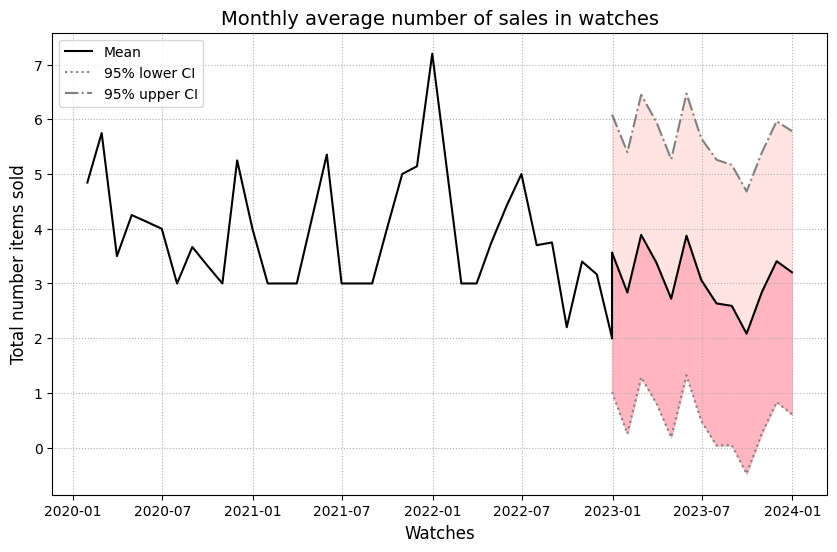

In [36]:
plot_forecast(monthly_historical_watches_no_na_df, monthly_forecast_watches_df, 'watches')

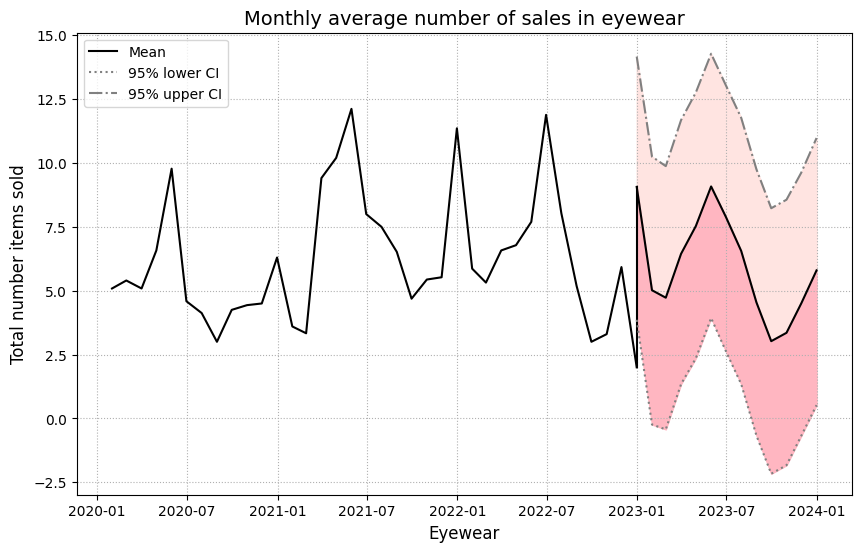

In [37]:
plot_forecast(monthly_historical_eyewear_df, monthly_forecast_eyewear_df, 'eyewear')

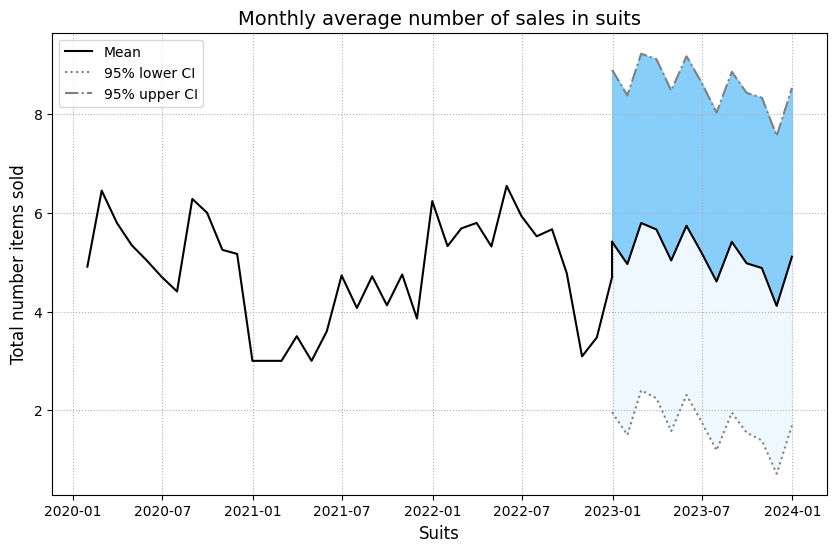

In [55]:
plot_forecast(monthly_historical_suits_df, monthly_forecast_suits_df, 'suits', 'lightskyblue', 'aliceblue')